# Previsão de Churn

### Discente(s):

    Bruno Antonio dos Santos Bezerra
    Erick Vinicius Rebouças Cruz
    Gabriel Monteiro Lobão

### Framework:
    TensorFlow/Keras

### Requerimentos:
    1. Python 3.9
    2. Tensorflow (conda install -c conda-forge tensorflow-gpu=2.10)
    3. Pandas
    4. Matplotlib
    5. Sklearn
    6. Numpy
    7. Dataset: https://www.kaggle.com/datasets/kapturovalexander/customers-churned-in-telecom-services

### Etapas do Projeto:
    1. Carregamento e Exploração dos Dados
    2. Pré-processamento
    3. Otimização de Hiperparâmetros com Optuna
    4. Analisando dados encontrados
    5. Criação do Modelo KAN ()
    6. Treinamento e Validação do Modelo
    7. Avaliação e Previsões
    8. Previsão Futura (Exemplo)




# 1. Importação de Bibliotecas e dados

In [3]:
import numpy as np # Manipulação de dados numéricos e estruturados.
import pandas as pd
import matplotlib.pyplot as plt # Geração de gráficos.
from sklearn.preprocessing import StandardScaler # Normalização dos dados.
from sklearn.preprocessing import OneHotEncoder # Codificação de variáveis categóricas.

import optuna # Otimização de hiperparâmetros.
from tensorflow.keras.optimizers import Adam # Algoritmo de otimização para treinar a rede neural.
from sklearn.metrics import r2_score # Avaliação da precisão do modelo.
from sklearn.model_selection import KFold
import seaborn as sns

/home/ph/googleDrive/STUDYING/UFPE/IF702 RN/Projeto-IF702/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-02-21 11:01:46.944777: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-21 11:01:46.960858: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740146506.974349  178703 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740146506.

In [25]:
df_original = pd.read_csv('data/customer_churn_telecom_services.csv')
df = df_original
print("Database shape:", df.shape)
df.head()

Database shape: (7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [26]:
df = df.drop(columns=["customerID"])
# data_positive = df[df['Churn'] == 'Yes']
# data_negative = df[df['Churn'] == 'No']
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [28]:
kf = KFold(n_splits=3, shuffle=True, random_state=42)  # Shuffle para garantir aleatoriedade
folds = []

for train_index, test_index in kf.split(df):
    train_fold = df.take(train_index)
    test_fold = df.take(test_index)
    
    # Dividir o conjunto de teste em validação e teste (50/50)
    val_size = len(test_fold) // 2
    val_fold = test_fold.head(val_size)
    test_fold = test_fold.tail(len(test_fold) - val_size)
    
    folds.append((train_fold, val_fold, test_fold))
    # Final: train 50%, validation 25%, test 25%

print("\nNúmero de registros por subset:")
for i, (train, val, test) in enumerate(folds):
    print(f"Fold {i+1}: Treino={len(train)}, Validação={len(val)}, Teste={len(test)}")


Número de registros por subset:
Fold 1: Treino=4695, Validação=1174, Teste=1174
Fold 2: Treino=4695, Validação=1174, Teste=1174
Fold 3: Treino=4696, Validação=1173, Teste=1174


# 2. Analise dos dados

Resumo estatístico para números:


,SeniorCitizen,tenure,MonthlyCharges
count,5869.000000,5869.000000,5869.000000
mean,0.160334,32.339922,64.744471
std,0.366947,24.564547,30.083070
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.400000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.650000


Resumo estatístico para literais:


,gender,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,TotalCharges,Churn
count,5869,5869,5869,5869,5869,5869,5869,5869,5869,5869,5869,5869,5869,5869,5869,5869,5869
unique,2,2,2,2,3,3,3,3,3,3,3,3,3,2,4,5501,2
top,Male,No,No,Yes,No,Fiber optic,No,No,No,No,No,Yes,Month-to-month,Yes,Electronic check,,No
freq,3001,3030,4105,5315,2836,2569,2908,2570,2587,2896,2332,2296,3214,3473,1984,9,4316


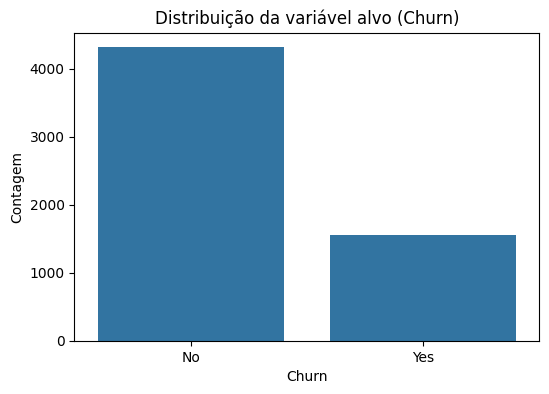

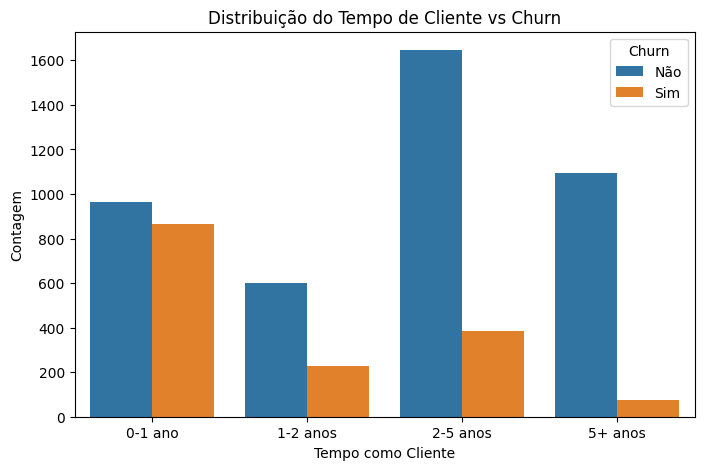

/tmp/ipykernel_178703/2451056622.py:28: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  churn_counts = eda_df.groupby("MonthlyCharges_category")["Churn"].value_counts(normalize=True).unstack()


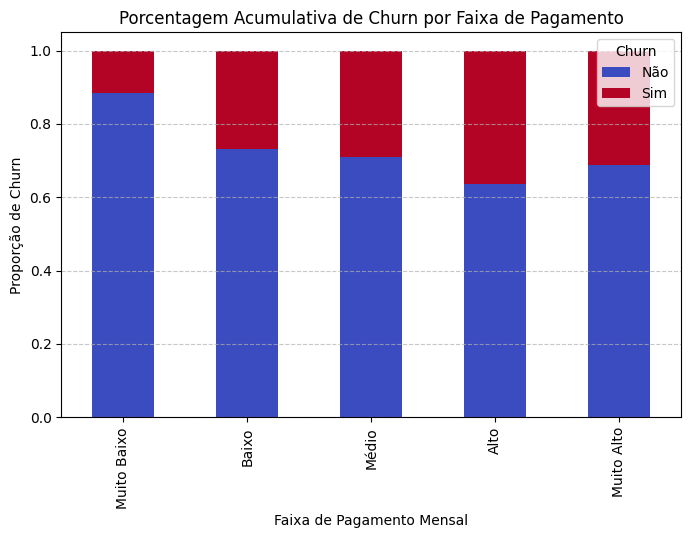

In [37]:

# Análise Exploratória de Dados (EDA) - usando apenas treino e validação!
train_df, val_df, _ = folds[0]  # Pegamos um dos folds para análise
eda_df = pd.concat([train_df, val_df])  # Apenas treino + validação

#  Resumo estatístico das variáveis
print("Resumo estatístico para números:")
display(pd.DataFrame(eda_df.select_dtypes(include=['number']).describe()))
print("Resumo estatístico para literais:")
display(pd.DataFrame(eda_df.select_dtypes(exclude=['number']).describe()))

plt.figure(figsize=(6, 4))
sns.countplot(x=eda_df["Churn"])
plt.title("Distribuição da variável alvo (Churn)")
plt.xlabel("Churn")
plt.ylabel("Contagem")
plt.show()

eda_df["tenure_category"] = pd.cut(eda_df["tenure"], bins=[0, 12, 24, 60, 120], labels=["0-1 ano", "1-2 anos", "2-5 anos", "5+ anos"])
plt.figure(figsize=(8, 5))
sns.countplot(x=eda_df["tenure_category"], hue=eda_df["Churn"])
plt.title("Distribuição do Tempo de Cliente vs Churn")
plt.xlabel("Tempo como Cliente")
plt.ylabel("Contagem")
plt.legend(title="Churn", labels=["Não", "Sim"])
plt.show()

eda_df["MonthlyCharges_category"] = pd.cut(eda_df["MonthlyCharges"], bins=5, labels=["Muito Baixo", "Baixo", "Médio", "Alto", "Muito Alto"])
churn_counts = eda_df.groupby("MonthlyCharges_category")["Churn"].value_counts(normalize=True).unstack()
churn_counts.plot(kind="bar", stacked=True, figsize=(8, 5), colormap="coolwarm")
plt.title("Porcentagem Acumulativa de Churn por Faixa de Pagamento")
plt.xlabel("Faixa de Pagamento Mensal")
plt.ylabel("Proporção de Churn")
plt.legend(title="Churn", labels=["Não", "Sim"])
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

# 3. Pre-processamento de dados

In [33]:
df[['Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'Churn']] = df[['Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'Churn']].replace({'Yes': 1, 'No': 0})
df[['MultipleLines', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']] = df[['MultipleLines', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']].replace({'Yes': 1, 'No': 0, 'No internet service': 0})
df['gender'] = df['gender'].replace({'Female':1, 'Male':0})
#df['InternetService'] = df['InternetService'].replace({'Fiber optic': 2, 'DSL': 1 , 'No': 0})
df['MultipleLines'] =  df['MultipleLines'].replace({'No phone service': -1})
df.head()

/tmp/ipykernel_4417/1775762302.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[['Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'Churn']] = df[['Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'Churn']].replace({'Yes': 1, 'No': 0})
/tmp/ipykernel_4417/1775762302.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[['MultipleLines', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']] = df[['MultipleLines', 'OnlineSecurity', 'OnlineBackup', 'Device

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,1,0,1,0,1,0,-1,DSL,0,1,0,0,0,0,Month-to-month,1,Electronic check,29.85,29.85,0
1,0,0,0,0,34,1,0,DSL,1,0,1,0,0,0,One year,0,Mailed check,56.95,1889.50,0
2,0,0,0,0,2,1,0,DSL,1,1,0,0,0,0,Month-to-month,1,Mailed check,53.85,108.15,1
3,0,0,0,0,45,0,-1,DSL,1,0,1,1,0,0,One year,0,Bank transfer (automatic),42.30,1840.75,0
4,1,0,0,0,2,1,0,Fiber optic,0,0,0,0,0,0,Month-to-month,1,Electronic check,70.70,151.65,1


In [ ]:
colunas = ['PaymentMethod', 'Contract', 'InternetService']
ohe = OneHotEncoder(dtype=int)

colunas_ohe = ohe.fit_transform(df[colunas]).toarray()
dados = pd.concat([df, pd.DataFrame(colunas_ohe, columns=ohe.get_feature_names_out(colunas))], axis=1)

dados2 = dados.drop(colunas, axis=1)
dados2

0       0
1       0
2       1
3       0
4       1
       ..
7038    0
7039    0
7040    0
7041    1
7042    0
Name: Churn, Length: 7043, dtype: int64

In [32]:
df['PhoneService'].unique()

array([0, 1])

In [33]:
df.drop(columns=['Contract', 'PaymentMethod'], inplace=True)

KeyError: "['Contract', 'PaymentMethod'] not found in axis"

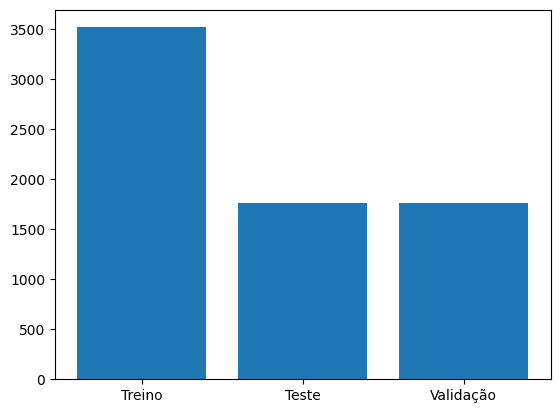

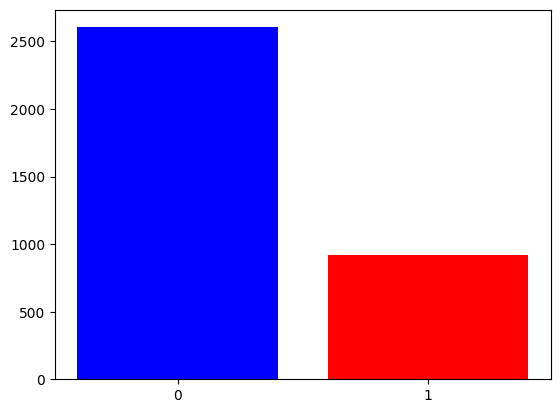

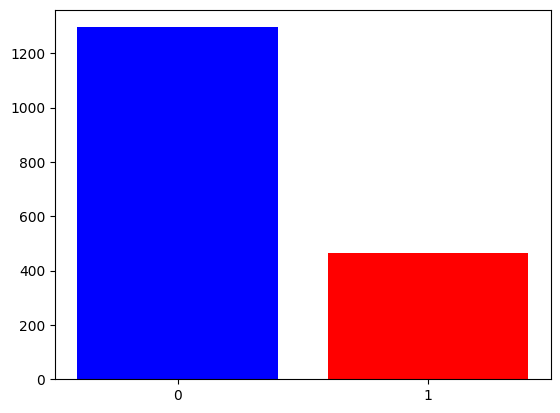

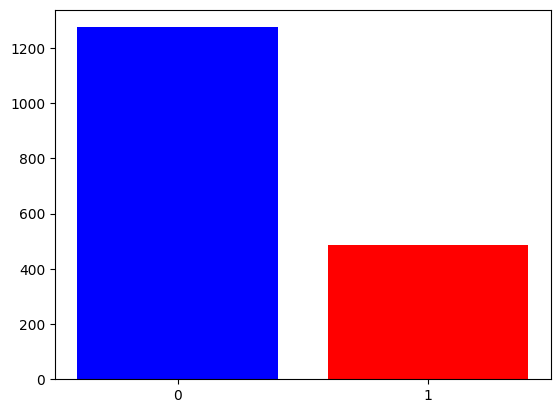

In [ ]:
# Separando os dados de treino e teste. 50% dos dados serão usados para treino e 25% para teste e 25% para validação.
# Usar K-fold para validação cruzada
porcentagem = 0.5

df_treino = df[:int(len(df)*porcentagem)]
df_test_val = df[int(len(df)*porcentagem):]

df_validacao = df_test_val[int(len(df_test_val)*porcentagem):]
df_test = df_test_val[:int(len(df_test_val)*porcentagem)]


# Plotando a quantidade de dados de treino e teste.
plt.bar(['Treino', 'Teste', 'Validação'], [df_treino.shape[0], df_test.shape[0], df_validacao.shape[0]])
plt.show()

plt.bar(df_treino['Churn'].value_counts().index, df_treino['Churn'].value_counts(), color=['blue', 'red'])
plt.xticks([0, 1])
plt.show()

plt.bar(df_test['Churn'].value_counts().index, df_test['Churn'].value_counts(), color=['blue', 'red'])
plt.xticks([0, 1])
plt.show()

plt.bar(df_validacao['Churn'].value_counts().index, df_validacao['Churn'].value_counts(), color=['blue', 'red'])
plt.xticks([0, 1])
plt.show()


# Separando os dados de entrada e saída.
X_treino = df_treino.drop(columns=['Churn'])
y_treino = df_treino['Churn']

X_test = df_test.drop(columns=['Churn'])
y_test = df_test['Churn']

X_val = df_validacao.drop(columns=['Churn'])
y_val = df_validacao['Churn']


In [45]:
X_treino

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,PaperlessBilling,MonthlyCharges,TotalCharges
0,1,0,1,0,1,0,-1,1,0,1,0,0,0,0,1,29.85,29.85
1,0,0,0,0,34,1,0,1,1,0,1,0,0,0,0,56.95,1889.50
2,0,0,0,0,2,1,0,1,1,1,0,0,0,0,1,53.85,108.15
3,0,0,0,0,45,0,-1,1,1,0,1,1,0,0,0,42.30,1840.75
4,1,0,0,0,2,1,0,2,0,0,0,0,0,0,1,70.70,151.65
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3516,0,0,0,0,3,1,0,1,0,0,0,0,0,0,1,43.30,123.65
3517,0,0,1,0,70,1,0,2,1,1,1,1,1,1,1,109.50,7534.65
3518,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,19.45,19.45
3519,0,1,0,0,43,1,1,2,0,0,0,0,1,0,1,84.85,3645.60


In [46]:


scaler = StandardScaler()
X_train = scaler.fit_transform(X_treino)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)



In [48]:
X_train.shape

(3521, 17)

In [ ]:
#Data Cleaning



### MLP

In [43]:
X_train

array([[ 1.0203722 , -0.43211178,  1.03733376, ...,  0.83087331,
        -1.16676003, -0.9912833 ],
       [-0.98003454, -0.43211178, -0.96400989, ..., -1.20355292,
        -0.26650732, -0.17085759],
       [-0.98003454, -0.43211178, -0.96400989, ...,  0.83087331,
        -0.36948826, -0.95673952],
       ...,
       [-0.98003454, -0.43211178, -0.96400989, ..., -1.20355292,
        -1.51224447, -0.99587149],
       [-0.98003454,  2.31421599, -0.96400989, ...,  0.83087331,
         0.66032112,  0.60388475],
       [ 1.0203722 , -0.43211178,  1.03733376, ..., -1.20355292,
        -1.50726152, -0.86572571]])

In [1]:
import tensorflow as tf

def create_model(trial, input_dim):
    model = tf.keras.Sequential()
    # Camada de entrada
    model.add(tf.keras.layers.Input(shape=(input_dim,)))
    
    # Número de camadas ocultas a serem utilizadas
    n_layers = trial.suggest_int('n_layers', 1, 3)
    
    # Adicionando as camadas ocultas
    for i in range(n_layers):
        num_units = trial.suggest_int(f'n_units_{i}', 16, 128)
        model.add(tf.keras.layers.Dense(num_units, activation='relu'))
        # Adiciona dropout se o valor sugerido for maior que 0
        dropout_rate = trial.suggest_float(f'dropout_{i}', 0.0, 0.5)
        if dropout_rate > 0.0:
            model.add(tf.keras.layers.Dropout(dropout_rate))
    
    # Camada de saída para classificação binária
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    
    # Taxa de aprendizado para o otimizador
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy']) # Cross-entropy ou MSE
    return model

def objective(trial):
    input_dim = X_treino.shape[1]
    model = create_model(trial, input_dim)
    
    # Otimização do tamanho do batch
    batch_size = trial.suggest_int('batch_size', 16, 128)
    
    # Callback para early stopping (para interromper o treinamento se a loss de validação não melhorar)
    early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    
    # Treinamento do modelo
    model.fit(
        X_treino, y_treino,
        validation_data=(X_val, y_val),
        epochs=50,
        batch_size=batch_size,
        callbacks=[early_stop],
        verbose=0
    )
    
    # Avaliação do modelo no conjunto de validação (a métrica utilizada aqui é a loss)
    score = model.evaluate(X_val, y_val, verbose=0)
    val_loss = score[0]
    return val_loss

# Criação do estudo com direção de minimização (pois desejamos minimizar a loss)
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)
print("Melhores hiperparâmetros:", study.best_trial.params)

# Salvando os resultados do estudo em CSV e Excel

# Converte os dados dos trials para um DataFrame
df_trials = study.trials_dataframe()

# Salva em CSV
df_trials.to_csv('MLP_results.csv', index=False)
print("Resultados salvos em 'optuna_results.csv'.")

# Salva em Excel (certifique-se de ter o pacote openpyxl instalado)
df_trials.to_excel('optuna_results.xlsx', index=False)
print("Resultados salvos em 'optuna_results.xlsx'.")

# Opcional: Avaliação do modelo final no conjunto de teste utilizando os melhores hiperparâmetros
best_trial = study.best_trial
best_model = create_model(optuna.trial.FixedTrial(best_trial.params), X_treino.shape[1])
history = best_model.fit(
    X_treino, y_treino,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=best_trial.params.get('batch_size', 32),
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)],
    verbose=0
)
test_score = best_model.evaluate(X_test, y_test, verbose=0)
print(f"Loss no conjunto de teste: {test_score[0]:.4f} - Acurácia: {test_score[1]:.4f}")


2025-02-17 13:16:48.551702: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


NameError: name 'optuna' is not defined

In [ ]:
from Kantf import KAN

model = KAN([
    {'in_features': 784, 'out_features': 64, 'grid_size': 5, 'spline_order': 3, 'activation': 'silu'},
    {'in_features': 64, 'out_features': 10, 'grid_size': 5, 'spline_order': 3, 'activation': 'silu'}
])

2025-02-17 10:55:56.278223: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-02-17 10:55:56.400139: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-02-17 10:55:56.403114: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-02-17 10:55:56.406021: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropri

In [ ]:
import tensorflow as tf
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy
from tensorflow.keras.optimizers import Adam


model.compile(optimizer=Adam(learning_rate=1e-3), loss=SparseCategoricalCrossentropy(from_logits=True))

# Metrics
train_loss = tf.keras.metrics.Mean(name='train_loss')
val_loss = tf.keras.metrics.Mean(name='val_loss')
val_accuracy = SparseCategoricalAccuracy(name='val_accuracy')

# Lists to store metrics for plotting
epoch_train_loss = []
epoch_val_loss = []
epoch_val_accuracy = []

for epoch in range(epochs):
    train_loss.reset_states()
    val_loss.reset_states()
    val_accuracy.reset_states()

    # Existing training and validation loop here ...

    # Append metrics after each epoch
    epoch_train_loss.append(train_loss.result().numpy())
    epoch_val_loss.append(val_loss.result().numpy())
    epoch_val_accuracy.append(val_accuracy.result().numpy())

    print(f'Epoch {epoch + 1}, Train Loss: {train_loss.result():.4f}, Validation Loss: {val_loss.result():.4f}, Validation Accuracy: {val_accuracy.result():.4f}')

NameError: name 'epochs' is not defined